In [16]:
import torch
from transformers import AutoModelForSequenceClassification
import pandas as pd
import numpy as np
import evaluate
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
model = AutoModelForSequenceClassification.from_pretrained("VCNC/Auto-CNC").to(device)

In [4]:
tokens = {"other":0, "1200":1, "1300":2, "1400":3, "1600":4, "1700":5, "1800":6, "1900":7, "2100":8, "2400":9, "2405":9, "2600":10, "2800":11, 
          "2805":11, "AR-10":12, "AR-20":12, "AR-30":12, "AR-40":12, "AR-50":12, "AR-70":12, "AR-90":12}

In [5]:
df = pd.read_hdf('./datasets/data.h5', keys='df')
df

,PEDIDO,FE_EMIT,FE_ENTREGA,X,y
3503,56227,737304,737304,[0],[0]
3502,56226,737305,737305,[6],[6]
3501,56231,737306,737306,[6],[6]
3499,56238,737318,737318,"[11, 0]",[11]
3500,56244,737318,737318,"[11, 0]",[0]
...,...,...,...,...,...
4,60629,738513,738759,"[10, 10, 10, 10, 10, 10, 10, 10, 10, 10]",[10]
3,60644,738513,738759,"[10, 10, 10, 10, 10, 10, 10, 10, 10, 10]",[10]
2,60643,738513,738759,"[10, 10, 10, 10, 10, 10, 10, 10, 10, 10]",[10]
1,60604,738513,738759,"[10, 10, 10, 10, 10, 10, 10, 10, 10, 10]",[10]


In [6]:
#Misma lógica que al finetunear
df['X_tuple'] = df.X.apply(tuple)
df['y_tuple'] = df.y.apply(tuple)
df = df.drop_duplicates(subset=['X_tuple', 'y_tuple']) #Eliminamos los datos replicados X->y
df = df.drop(labels=['FE_EMIT', 'FE_ENTREGA', 'PEDIDO', 'X_tuple', 'y_tuple'], axis=1) #Eliminamos columnas que no son útiles
df['y'] = df['y'].apply(lambda x: x[0])
df

,X,y
3503,[0],0
3502,[6],6
3499,"[11, 0]",11
3500,"[11, 0]",0
3497,"[6, 11]",6
...,...,...
31,"[6, 6, 6, 6, 11, 11, 11, 0, 11, 11, 11, 11, 11...",0
22,"[11, 11, 11, 11, 11, 10, 10, 10, 10, 11, 11, 1...",11
17,"[11, 11, 11, 11, 11, 10, 10, 10, 10, 11, 11, 1...",10
10,"[11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 1...",11


In [7]:
#Definimos funciones que son necesarias para el input de BERT, consultese: https://huggingface.co/learn/nlp-course/chapter3/2?fw=pt para más información
from typing import Union
#Función para padear las secuencias
def pad(max_len:int, sequence:Union[list, np.array], pad_token:int=21):
  padding = np.full(max_len-len(sequence), pad_token)
  padded_seq = np.concatenate((sequence, padding))
  return padded_seq.tolist()

#Función para crear las máscaras de atención
def attention_mask(pad_sequence:Union[list, np.array], pad_token:int=21):
  seq = np.asarray(pad_sequence, dtype=int)
  attention_mask = np.asarray(seq != pad_token, dtype=int)
  return attention_mask.tolist()

#Función para crear los arreglos que especifican el tipo de token
def token_types(pad_sequence:Union[list, np.array]):
  return np.zeros(len(pad_sequence), dtype=int).tolist()

In [8]:
#Preparamos el df para BERT con las columnas que requiere('idx', 'label', 'input_ids', 'attention_mask', 'token_type_ids')
max_len = df.X.apply(lambda x: len(x))
max_len = max(max_len)
dt = df.copy(True)
PAD = 13

dt.insert(0, 'idx', np.full(len(df), np.nan))
dt.insert(1, 'label', dt.y)
dt.insert(2, 'input_ids', np.full(len(df), np.nan))
dt.insert(3, 'attention_mask', np.full(len(df), np.nan))
dt.insert(4, 'token_type_ids', np.full(len(df), np.nan))
data = dt.to_numpy()

for i in range(len(data)):
  data[i][2] = pad(max_len, data[i][5], pad_token=PAD)
  data[i][3] = attention_mask(data[i][2], pad_token=PAD)
  data[i][4] = token_types(data[i][2])
dt['input_ids'] = data[:, 2]
dt['attention_mask'] = data[:, 3]
dt['token_type_ids'] = data[:, 4]
df = dt.copy(True)
df

,idx,label,input_ids,attention_mask,token_type_ids,X,y
3503,NaN,0,"[0, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[0],0
3502,NaN,6,"[6, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[6],6
3499,NaN,11,"[11, 0, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[11, 0]",11
3500,NaN,0,"[11, 0, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[11, 0]",0
3497,NaN,6,"[6, 11, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[6, 11]",6
...,...,...,...,...,...,...,...
31,NaN,0,"[6, 6, 6, 6, 11, 11, 11, 0, 11, 11, 11, 11, 11...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[6, 6, 6, 6, 11, 11, 11, 0, 11, 11, 11, 11, 11...",0
22,NaN,11,"[11, 11, 11, 11, 11, 10, 10, 10, 10, 11, 11, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[11, 11, 11, 11, 11, 10, 10, 10, 10, 11, 11, 1...",11
17,NaN,10,"[11, 11, 11, 11, 11, 10, 10, 10, 10, 11, 11, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[11, 11, 11, 11, 11, 10, 10, 10, 10, 11, 11, 1...",10
10,NaN,11,"[11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 1...",11


In [9]:
data = df.to_numpy()
input_ids = np.asarray([np.asarray(i, dtype=int) for i in data[:, 2]])
input_ids = torch.tensor(input_ids).to(device)

attention_mask = np.asarray([np.asarray(i, dtype=int) for i in data[:, 3]])
attention_mask = torch.tensor(attention_mask).to(device)

token_type_ids = np.asarray([np.asarray(i, dtype=int) for i in data[:, 4]])
token_type_ids = torch.tensor(token_type_ids).to(device)

In [10]:
#Hay que usar el no_grad ya que de otra forma se irán acumulando gradientes en el cache y eventualmente nos quedaremos sin memoria
with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

In [11]:
torch.cuda.empty_cache()

In [12]:
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[ 1.2573, -4.4179, -5.0829,  ..., -2.9330, -2.2065, -4.3143],
        [-3.4982, -4.0652, -5.7954,  ..., -3.8692, -3.0606, -3.9388],
        [-3.0213, -4.5947, -5.9190,  ..., -3.6186,  1.3776, -4.2018],
        ...,
        [-3.7164, -4.2936, -5.7488,  ..., -3.2248,  1.5418, -4.0179],
        [-3.6662, -4.2763, -5.7008,  ..., -3.0506,  1.5444, -4.0326],
        [-2.9710, -3.1360, -4.0840,  ...,  2.1366, -2.7066, -3.1510]],
       device='cuda:0'), hidden_states=None, attentions=None)

In [13]:
def compute_metrics(eval_preds):
    metric = evaluate.load("accuracy")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    ord = np.argsort(logits, axis=-1) #Ordenamos los índices de los logits de menor a mayor
    sec_pred = ord[:, -2]
    third_pred = ord[:, -3]
    accuracy1 = metric.compute(predictions=predictions, references=labels)['accuracy']
    accuracy = accuracy1
    accuracy += metric.compute(predictions=sec_pred, references=labels)['accuracy']
    accuracy += metric.compute(predictions=third_pred, references=labels)['accuracy']
    print(f"La accuracy con el mayor logit es: {accuracy1} \nLa accuracy tomando el top 3 es: {accuracy}")

In [14]:
labels = df.y.to_numpy()
compute_metrics([outputs['logits'].cpu(), labels])

La accuracy con el mayor logit es: 0.6146384479717814 
La accuracy tomando el top 3 es: 0.8544973544973545


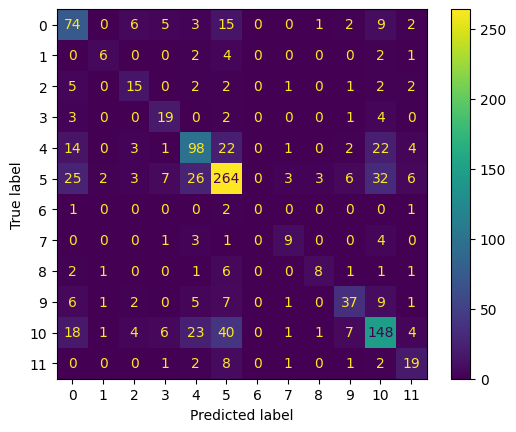

In [22]:
#Creamos una matriz de confusión para analizar el error
predictions = np.argmax(outputs['logits'].cpu(), axis=-1)
confusion_matrix = metrics.confusion_matrix(labels, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [i for i in range(12)])
cm_display.plot()
plt.show()

In [38]:
#La función preprocess una vez entrada una lista con la descripción de los productos logra preprocesar la entrada para BERT
def preprocess(input:list[str], tokens):
    keys = [i for i in tokens.keys()]
    processed = np.zeros(len(input), dtype=int)
    for i in range(len(input)):
        for k in keys:
            if k in input[i]:
                processed[i] = tokens[k]
                break
            else:
                processed[i] = tokens['other']
    return torch.tensor(np.asarray([processed]))

In [40]:
#Código para hacer inferencia
tokens = {"other":0, "1200":1, "1300":2, "1400":3, "1600":4, "1700":5, "1800":6, "1900":7, "2100":8, "2400":9, "2405":9, "2600":10, "2800":11, 
          "2805":11, "AR-10":12, "AR-20":12, "AR-30":12, "AR-40":12, "AR-50":12, "AR-70":12, "AR-90":12}
input = ['1800-ARK', '1200 TAPA 6','1200 CINCO ROSCAS','1200 DADO VUELTA','1600','1800', '1200', '1200' 'other']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_ids = preprocess(input, tokens).to(device)
model = AutoModelForSequenceClassification.from_pretrained("VCNC/Auto-CNC").to(device)
output = model(input_ids)['logits']
output

tensor([[-3.5771, -4.0238, -5.6223, -4.3224, -4.5955, -3.2697,  2.4135, -4.8891,
         -4.5398, -3.9405, -3.8141, -3.1982, -3.9566]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

Terminamos!!! 🎉🤗🎉